# TCLAB Impedance

In [1]:
import math
import time

import numpy as np
import pandas as pd
import tclab
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sqlalchemy import create_engine

## Record

In [5]:
TCLab = tclab.setup(connected=True)

with TCLab() as lab:
    print(lab.T1, lab.T2)
    lab.Q1(50)
    lab.Q2(40)
    
    for _ in range(60):
        time.sleep(0.1)
        print(lab.T1, lab.T2)

TCLab version 1.0.0
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
28.246 25.7
28.182 25.797
28.278 25.732
28.278 25.668
28.311 25.732
28.311 25.797
28.278 25.861
28.278 25.7
28.311 25.7
28.311 25.797
28.311 25.861
28.311 25.732
28.311 25.765
28.311 25.829
28.311 25.926
28.311 25.732
28.214 25.861
28.311 25.958
28.311 25.926
28.311 25.7
28.311 25.829
28.311 25.926
28.311 25.861
28.311 25.7
28.311 25.797
28.311 25.861
28.311 25.861
28.311 25.765
28.311 25.668
28.311 25.829
28.311 25.861
28.311 25.7
28.311 25.797
28.311 25.861
28.311 25.861
28.311 25.732
28.311 25.797
28.311 25.958
28.343 25.99
28.311 25.732
28.311 25.861
28.311 25.926
28.343 25.958
28.343 25.732
28.375 26.022
28.375 26.055
28.536 25.894
28.375 25.958
28.407 25.99
28.536 26.055
28.568 26.119
28.536 25.926
28.633 26.119
28.633 26.184
28.633 25.958
28.633 26.022
28.633 26.216
28.633 26.151
28.633 26.184
28.633 26.022
28.665 26.184
TCLab disconnected successfully

In [12]:
with TCLab() as lab:
    t1 = time.time()
    for _ in range(1_000):
        lab.T1
        #lab.Q1(50)
    t2 = time.time()
    print((t2 - t1)/1_000)

TCLab version 1.0.0
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
0.06776974940299987
TCLab disconnected successfully.


In [331]:
measurement_frequencies = (1.0, 0.1, 0.01, 0.007, 0.005, 0.003, 0.001)
num_periods = 7
sampling_rate = 3  # Hz
sampling_rate

3

In [332]:
def phi(dt: float, period: float) -> float:
    return (dt / period) * 360


def new_temp(dt: float, freq: float) -> float:
    return 2 * math.sin(2 * math.pi * freq * dt) + 50

In [333]:
data = []

with TCLab() as lab:
    lab.Q1(50)
    prev_theta = lab.T1
    time.sleep(60)
    while abs(prev_theta - lab.T1) > 0.1:
        prev_theta = lab.T1
        print(prev_theta)
        time.sleep(30)

    for f in measurement_frequencies:
        # realign
        lab.Q1(50)
        time.sleep(120)
        start_time = time.time()

        steps = math.ceil(sampling_rate * (1 / f) * num_periods)
        print(f"Current Frequency: {f=}, planned {steps=}.")

        for i in range(steps):
            t1 = time.time()
            t = t1 - start_time

            theta = lab.T1
            heating = new_temp(t, f)
            lab.Q1(heating)
            data.append({"freq_Hz": f, "dt": t, "Q1_%": heating, "theta": theta})
            t2 = time.time()

            dt = t2 - t1
            time.sleep(1 / sampling_rate - dt)

TCLab version 1.0.0
Arduino Leonardo connected on port /dev/ttyACM0 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
36.625
39.912
42.49
44.746
46.68
48.291
49.516
50.354
51.191
51.868
52.48
53.125
53.447
54.027
54.124
54.414
54.736
Current Frequency: f=1.0, planned steps=21.
Current Frequency: f=0.1, planned steps=210.
Current Frequency: f=0.01, planned steps=2100.
Current Frequency: f=0.007, planned steps=3000.
Current Frequency: f=0.005, planned steps=4200.
Current Frequency: f=0.003, planned steps=7000.
Current Frequency: f=0.001, planned steps=21000.
TCLab disconnected successfully.


In [334]:
measurement_df = pd.DataFrame(data)
measurement_df

,freq_Hz,dt,Q1_%,theta
0,1.000,0.000175,50.002196,54.736
1,1.000,0.333649,51.730065,54.736
2,1.000,0.667131,48.265041,54.736
3,1.000,1.000710,50.008916,54.736
4,1.000,1.334367,51.725519,54.736
...,...,...,...,...
37526,0.001,7002.036107,50.025586,55.606
37527,0.001,7002.369560,50.029776,55.671
37528,0.001,7002.703007,50.033965,55.671
37529,0.001,7003.036438,50.038155,55.671


In [335]:
engine = create_engine("sqlite:///impedance_spectroscopy_measured_3Hz.db")
measurement_df.to_sql("impedance_spectroscopy_dummy", engine, if_exists="replace")

37531

## Use this Data

In [13]:
engine = create_engine("sqlite:///impedance_spectroscopy_measured_3Hz.db")
measurement_df = pd.read_sql_table("impedance_spectroscopy_dummy", engine)

In [14]:
def sin_func(x, a, b, phi, c):
    return a * np.sin(2 * np.pi * b * x + phi) + c

In [15]:
low_freq = 0.001
low_freq_df = measurement_df[measurement_df.freq_Hz == low_freq]
low_freq_df

,index,freq_Hz,dt,Q1_%,theta
16531,16531,0.001,0.000176,50.000002,56.348
16532,16532,0.001,0.333628,50.004192,56.348
16533,16533,0.001,0.667058,50.008382,56.348
16534,16534,0.001,1.000549,50.012573,56.348
16535,16535,0.001,1.334044,50.016764,56.348
...,...,...,...,...,...
37526,37526,0.001,7002.036107,50.025586,55.606
37527,37527,0.001,7002.369560,50.029776,55.671
37528,37528,0.001,7002.703007,50.033965,55.671
37529,37529,0.001,7003.036438,50.038155,55.671


### Darstellung 0.001 Hz

In [16]:
xdata = low_freq_df.dt.to_numpy()

popt_heat, pcov_heat = curve_fit(
    sin_func,
    xdata,
    low_freq_df["Q1_%"].to_numpy(),
    p0=[2, low_freq, 0.1, 50],
    bounds=([1, low_freq - low_freq / 10, 0.1, 47], [3, low_freq + low_freq / 10, 359, 53]),
)
popt_heat

array([1.99411921e+00, 9.96590598e-04, 1.00000000e-01, 5.00002170e+01])

In [17]:
popt_theta, pcov_theta = curve_fit(
    sin_func,
    xdata,
    low_freq_df.theta.to_numpy(),
    p0=[2, low_freq, 3, 56],
    bounds=([0.5, low_freq - low_freq / 10, 0.1, 54], [3, low_freq + low_freq / 10, 359, 58]),
)
popt_theta

array([9.35072747e-01, 9.95325807e-04, 5.56782064e+00, 5.62834649e+01])

In [18]:
x_fit = np.linspace(xdata[0], xdata[-1], 1000)
heat_fit = sin_func(x_fit, *popt_heat)

theta_fit = sin_func(x_fit, *popt_theta)

[Text(0.5, 0, 't [s]'), Text(0, 0.5, 'Heating [%]')]

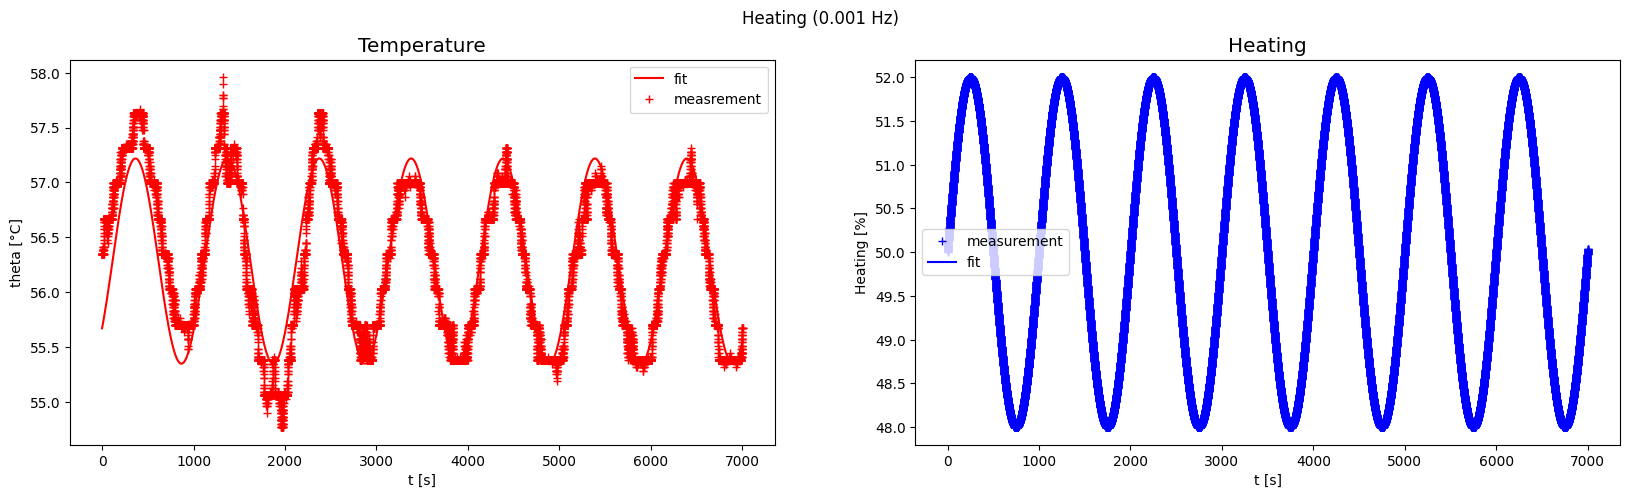

In [19]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 5))
fig.suptitle("Heating (0.001 Hz)")

axs[0].set_title("Temperature", fontsize="x-large")
axs[0].plot(x_fit, theta_fit, "r-", label="fit")
axs[0].plot(low_freq_df.dt, low_freq_df.theta, "r+", label="measrement")
axs[0].legend()
axs[0].set(xlabel="t [s]", ylabel="theta [°C]")

axs[1].set_title("Heating", fontsize="x-large")
axs[1].plot(low_freq_df.dt, low_freq_df["Q1_%"], "b+", label="measurement")
axs[1].plot(x_fit, heat_fit, "b-", label="fit")
axs[1].legend()
axs[1].set(xlabel="t [s]", ylabel="Heating [%]")

### Darstellung 0.01 Hz

In [25]:
high_freq = 0.01
high_freq_df = measurement_df[measurement_df.freq_Hz == high_freq]
high_freq_df

,index,freq_Hz,dt,Q1_%,theta
231,231,0.01,0.000281,50.000035,56.025
232,232,0.01,0.333713,50.041933,56.025
233,233,0.01,0.667404,50.083844,56.025
234,234,0.01,1.000887,50.125692,56.025
235,235,0.01,1.334361,50.167484,56.025
...,...,...,...,...,...
2326,2326,0.01,698.761473,49.844519,55.703
2327,2327,0.01,699.095138,49.886353,55.703
2328,2328,0.01,699.428603,49.928212,55.703
2329,2329,0.01,699.762035,49.970098,55.703


In [26]:
xdata = high_freq_df.dt.to_numpy()

popt_heat, pcov_heat = curve_fit(
    sin_func,
    xdata,
    high_freq_df["Q1_%"].to_numpy(),
    p0=[2, high_freq, 0.1, 50],
    bounds=([0, high_freq - high_freq / 10, 0.1, 47], [4, high_freq + high_freq / 10, 359, 53]),
)
popt_heat

array([1.99411173e+00, 9.96589671e-03, 1.00000000e-01, 5.00001613e+01])

In [27]:
popt_theta, pcov_theta = curve_fit(
    sin_func,
    xdata,
    high_freq_df.theta.to_numpy(),
    p0=[2, high_freq, 3, 53],
    bounds=([0.2, high_freq - high_freq / 10, 0.5, 52], [4, high_freq + high_freq / 10, 359, 58]),
)
popt_theta

array([2.00000000e-01, 1.01286905e-02, 3.40827136e+00, 5.59870607e+01])

In [28]:
x_fit = np.linspace(xdata[0], xdata[-1], 1000)
heat_fit = sin_func(x_fit, *popt_heat)

theta_fit = sin_func(x_fit, *popt_theta)

[Text(0.5, 0, 't [s]'), Text(0, 0.5, 'Heating [%]')]

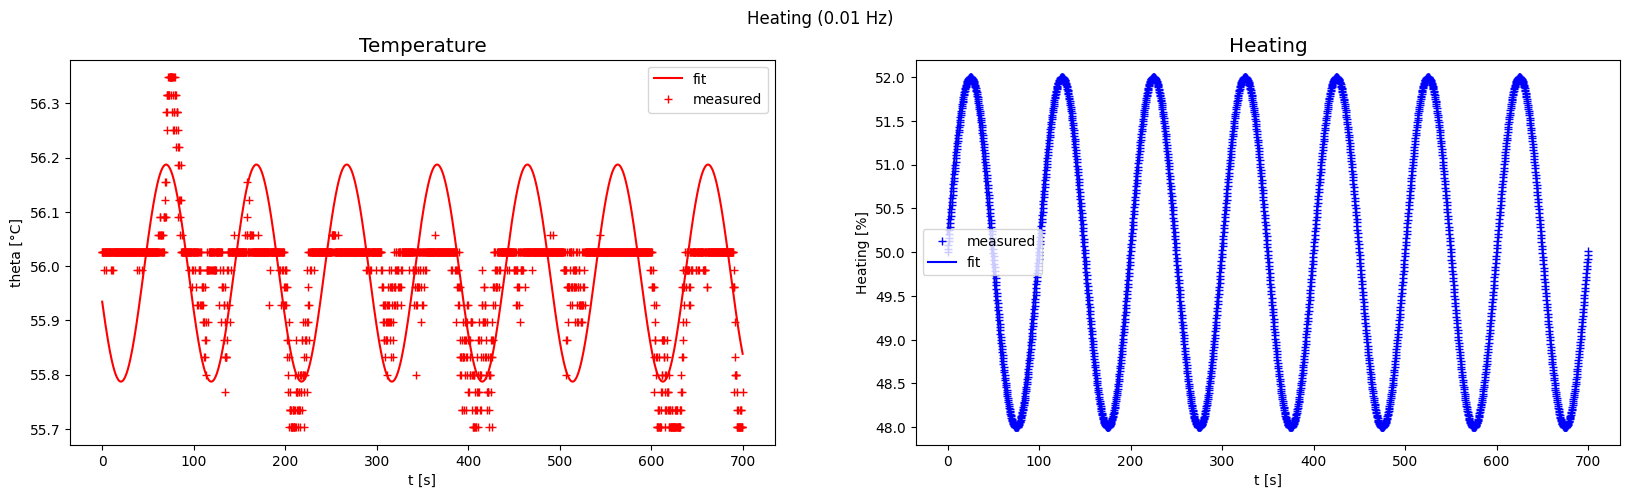

In [29]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 5))
fig.suptitle("Heating (0.01 Hz)")

axs[0].set_title("Temperature", fontsize="x-large")
axs[0].plot(x_fit, theta_fit, "r-", label="fit")
axs[0].plot(high_freq_df.dt, high_freq_df.theta, "r+", label="measured")
axs[0].legend()
axs[0].set(xlabel="t [s]", ylabel="theta [°C]")

axs[1].set_title("Heating", fontsize="x-large")
axs[1].plot(high_freq_df.dt, high_freq_df["Q1_%"], "b+", label="measured")
axs[1].plot(x_fit, heat_fit, "b-", label="fit")
axs[1].legend()
axs[1].set(xlabel="t [s]", ylabel="Heating [%]")

### Allgemein

In [35]:
interpol_data = []

for f in measurement_df.freq_Hz.unique():
    if f <= high_freq:
        freq_df = measurement_df[measurement_df.freq_Hz == f]
        print(len(freq_df))
        
        xdata = freq_df.dt.to_numpy()

        popt_theta, _ = curve_fit(
            sin_func,
            xdata,
            freq_df.theta.to_numpy(),
            p0=[2, f, 3, 54],
            bounds=([0, f - f / 10, 0.5, 47], [4, f + f / 10, 359, 58]),
            method="trf",
        )
        
        interpol_data.append({"freq_Hz": f, "Amplitude_theta": popt_theta[0], "phi": popt_theta[2]})

2100
3000
4200
7000
21000


In [37]:
interpol_df = pd.DataFrame(interpol_data)
interpol_df

,freq_Hz,Amplitude_theta,phi
0,0.010,0.076001,3.480898
1,0.007,0.160136,4.370238
2,0.005,0.240695,4.451942
3,0.003,0.396349,5.074155
4,0.001,0.935073,5.567822


[Text(0.5, 0, 'Phase'), Text(0, 0.5, 'Amplitude [°C]')]

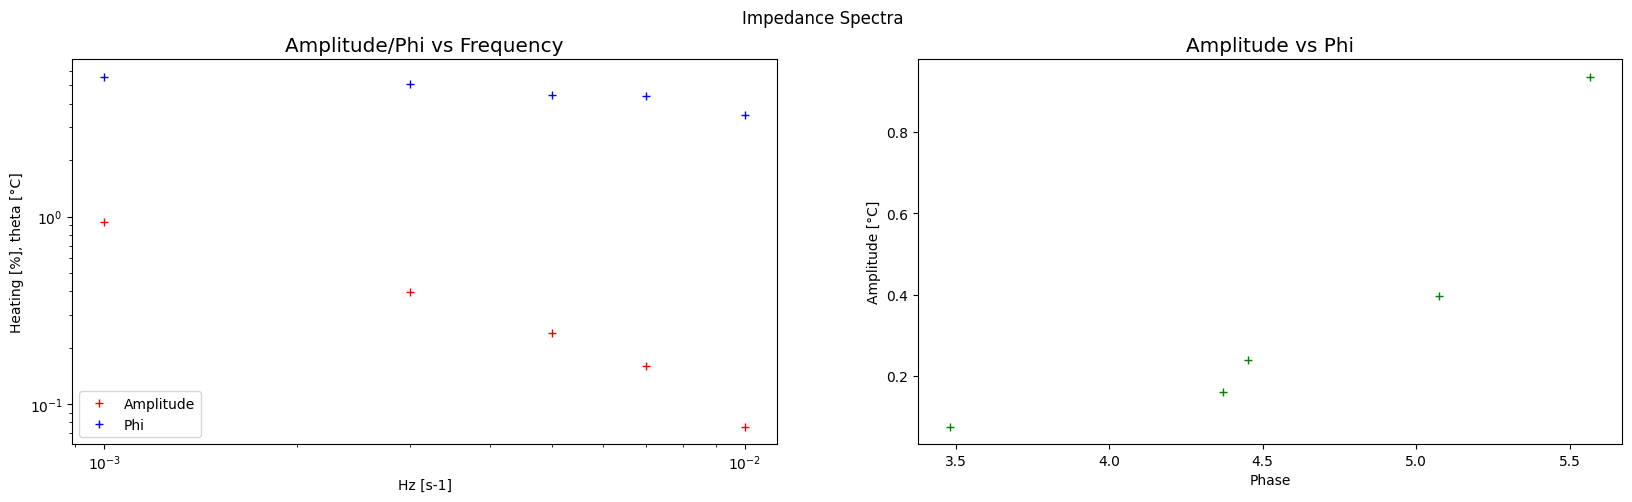

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Impedance Spectra")

axs[0].set_title("Amplitude/Phi vs Frequency", fontsize="x-large")
axs[0].plot(interpol_df.freq_Hz, interpol_df.Amplitude_theta, "r+", label="Amplitude")
axs[0].plot(interpol_df.freq_Hz, interpol_df.phi, "b+", label="Phi")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].legend()

axs[1].set_title("Amplitude vs Phi", fontsize="x-large")
axs[1].plot(interpol_df.phi, interpol_df.Amplitude_theta, "g+", label="Heating [%]")


axs[0].set(xlabel="Hz [s-1]", ylabel="Heating [%], theta [°C]")
axs[1].set(xlabel="Phase", ylabel="Amplitude [°C]")